## 多次元正規分布の最尤推定

D次元多次元正規分布の式

$$
\mathcal{N}(\bm{x}; \bm{\mu}, \bm{\Sigma}) = \frac{1}{\sqrt{(2\pi)^D |\Sigma|}} \exp\left( -\frac{1}{2} (\bm{x}-\bm{\mu})^\top \Sigma^{-1} (\bm{x} - \bm{\mu}) \right)
$$

この正規分布からサンプル $\mathcal{D} = \{\bm{x}^{(1)}, \bm{x}^{(2)}, \ldots, \bm{x}^{(N)}\}$ が得られたとき，パラメータ $\bm{\mu},\bm{\Sigma}$ は以下のように表される．

$$
\begin{align*}
    \hat{\bm{\mu}} &= \frac{1}{N} \sum_{n=1}^N \bm{x}^{(n)} \\
    \hat{\bm{\Sigma}} &= \frac{1}{N} \sum_{n=1}^N (\bm{x}^{(n)} - \hat{\bm{\mu}}) (\bm{x}^{(n)} - \hat{\bm{\mu}})^\top
\end{align*}
$$

In [2]:
// 依存関係のインストール
:dep image = "0.23"
:dep evcxr_image = "1.1"

// プロット用ライブラリ
:dep plotters = { version = "^0.3.5", default_features = false, features = ["evcxr", "all_series", "all_elements", "bitmap_backend", "full_palette", "colormaps"] }

// 乱数
:dep rand = "0.8.5"
:dep rand_distr = "0.4.3"

// 配列
:dep ndarray = { version = "0.15.6" }

In [3]:
// インポート
use evcxr_image::ImageDisplay;
use image::{GenericImage, imageops::FilterType};

use plotters::prelude::*;
use rand::prelude::*;

use ndarray::{Array, ArrayView, Axis, array, s};

In [4]:
:dep myml = { path = "../myml" }

In [5]:
use myml::{utility::linspace, normal::multivariate_normal};

In [6]:
const N: usize = 10000;
const D: usize = 2;

In [7]:
// 乱数生成器
let mut rng = thread_rng();

In [8]:
// (N, D)のランダムなデータを生成
let xs = (0..N)
    .map(|_| {
        array![rng.gen::<f64>(), rng.gen::<f64>()]
    })
    .collect::<Vec<_>>();

&xs[..2]

[[0.3052539939287727, 0.541577277864537], shape=[2], strides=[1], layout=CFcf (0xf), const ndim=1, [0.7778335525510288, 0.7498654193556943], shape=[2], strides=[1], layout=CFcf (0xf), const ndim=1]

In [9]:
// 最適なμを求める（ただの平均）
let mu = xs
    .iter()
    .fold(array![0.0, 0.0], |acc, x| acc + x)
    / N as f64;

&mu

[0.5019906745827899, 0.5031527902230702], shape=[2], strides=[1], layout=CFcf (0xf), const ndim=1

In [10]:
// 最適なΣを求める
let cov = xs
    .iter()
    .fold(
        array![[0.0, 0.0], [0.0, 0.0]],
        |acc, x| {
            let diff = (x - &mu).insert_axis(Axis(1));
            acc + diff.dot(&diff.t())
        }
    )
    / N as f64;

&cov

[[0.0828114581711606, 0.0006571584037164511],
 [0.0006571584037164511, 0.08312763555826726]], shape=[2, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2

重ねてプロットしてみる

参考：[plotters (BitMapBackend)をjupyter上で使う](https://github.com/dskkato/plotters-demo/blob/main/rust-bitmapbackend.ipynb)

In [11]:
:dep plotters-bitmap = "0.3.1"

In [12]:
use image::{GenericImage, GenericImageView, RgbImage, imageops::FilterType};

use plotters::backend::BitMapBackend;
use plotters_bitmap::bitmap_pixel::RGBPixel;

[src/lib.rs:159:5] pw = 400
[src/lib.rs:159:5] ph = 400
[src/lib.rs:159:5] xr = 0.0..1.0
[src/lib.rs:159:5] yr = 0.0..1.0


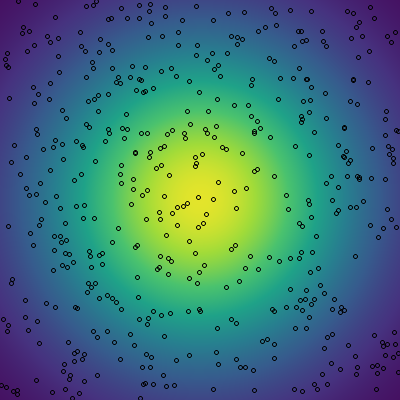

In [13]:
// なぜかevcxr_imageの一回目の画像表示は失敗する
// ImageBufferの数値が表示されてしまった場合、再度セルを実行すると画像が表示されるかもしれない。

let (width, height) = (400, 400);
let mut canvas = RgbImage::new(width, height);

{
    let mut buf = canvas.as_flat_samples_mut();

    // 白背景の描画領域を作る
    let root =
        BitMapBackend::<RGBPixel>::with_buffer_and_format(buf.as_mut_slice(), (width, height))?
        .into_drawing_area();
    root.fill(&WHITE);

    // プロット領域を作る
    let mut chart = ChartBuilder::on(&root)
        // .caption("y=x^2", ("Arial", 20).into_font())
        // .x_label_area_size(40)
        // .y_label_area_size(40)
        .build_cartesian_2d(0.0..1.0, 0.0..1.0)?;

    // プロット領域に描画
    let plotting_area = chart.plotting_area();
    let range = plotting_area.get_pixel_range();

    // 幅などの設定
    let (pw, ph) = (range.0.end - range.0.start, range.1.end - range.1.start);
    let (xr, yr) = (chart.x_range(), chart.y_range());

    dbg!(pw, ph, xr, yr);

    // モデルのプロット
    for x in linspace(-1.0, 1.0, 800) {
        for y in linspace(-1.0, 1.0, 800) {
            let p = array![[x, y]];
            let z = multivariate_normal(p.view(), mu.view(), cov.view()).unwrap()[0];
            let color = ViridisRGB::get_color(z * 0.5);

            plotting_area.draw_pixel((x, y), &color)?;
        }
    }

    // データのプロット
    chart.draw_series(
        xs[..500].iter().map(|x| Circle::new((x[0], x[1]), 2, &BLACK))
    )?;
}

canvas

### 実データのモデル化

In [14]:
use std::{fs::File, io::{self, prelude::*}, path::Path};

In [15]:
// ファイル
let height_file_path = Path::new("./data/height_weight.txt");

// 読み込み
let height_file = File::open(&height_file_path)?;
let reader = io::BufReader::new(height_file);
let height_weight_data = reader
    .lines()
    .filter_map(|line| line.ok())
    .filter_map(|val| {
        let mut itr = val.split_whitespace();
        let height = itr.next()?.parse::<f64>().ok()?;
        let weight = itr.next()?.parse::<f64>().ok()?;
        Some(array![height, weight])
    })
    .collect::<Vec<_>>();

// 読み取れていることを確認
&height_weight_data[..5]

[[167.089607, 51.252494], shape=[2], strides=[1], layout=CFcf (0xf), const ndim=1, [181.648633, 61.909547], shape=[2], strides=[1], layout=CFcf (0xf), const ndim=1, [176.2728, 69.411778], shape=[2], strides=[1], layout=CFcf (0xf), const ndim=1, [173.270164, 64.562199], shape=[2], strides=[1], layout=CFcf (0xf), const ndim=1, [172.181037, 65.45201], shape=[2], strides=[1], layout=CFcf (0xf), const ndim=1]

In [16]:
let n_data = height_weight_data.len();

In [17]:
// 最適なμを求める
let data_mu = height_weight_data
    .iter()
    .fold(array![0.0, 0.0], |acc, x| acc + x)
    / n_data as f64;

&data_mu

[172.70250853668063, 57.642208800960226], shape=[2], strides=[1], layout=CFcf (0xf), const ndim=1

In [18]:
// 最適なΣを求める
let data_cov = height_weight_data
    .iter()
    .fold(
        array![[0.0, 0.0], [0.0, 0.0]],
        |acc, x| {
            let diff = (x - &data_mu).insert_axis(Axis(1));
            acc + diff.dot(&diff.t())
        }
    )
    / n_data as f64;

&data_cov

[[23.330517821055636, 12.846850871078283],
 [12.846850871078283, 27.975468013151456]], shape=[2, 2], strides=[2, 1], layout=Cc (0x5), const ndim=2

[src/lib.rs:181:5] pw = 600
[src/lib.rs:181:5] ph = 600
[src/lib.rs:181:5] xr = 150.0..190.0
[src/lib.rs:181:5] yr = 40.0..80.0


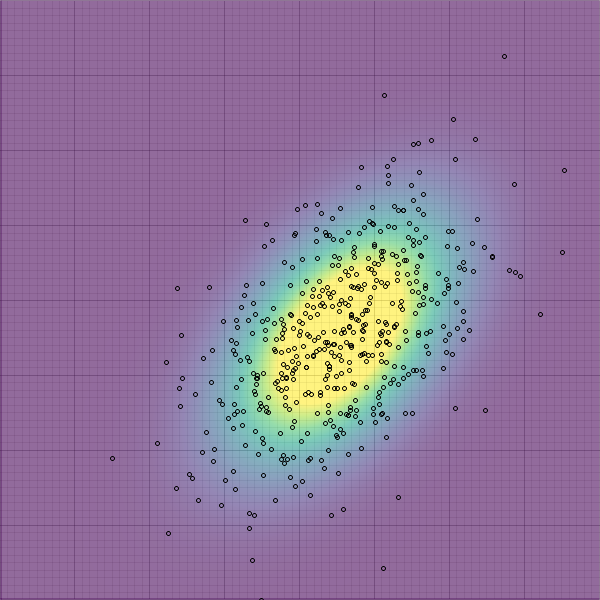

In [19]:
// なぜかevcxr_imageの一回目の画像表示は失敗する
// ImageBufferの数値が表示されてしまった場合、再度セルを実行すると画像が表示されるかもしれない。

let (width, height) = (600, 600);
let mut canvas = RgbImage::new(width, height);

{
    let mut buf = canvas.as_flat_samples_mut();

    // 白背景の描画領域を作る
    let root =
        BitMapBackend::<RGBPixel>::with_buffer_and_format(buf.as_mut_slice(), (width, height))?
        .into_drawing_area();
    root.fill(&WHITE);

    // プロット領域を作る
    let mut chart = ChartBuilder::on(&root)
        // .caption("y=x^2", ("Arial", 20).into_font())
        // .x_label_area_size(40)
        // .y_label_area_size(40)
        .build_cartesian_2d(150.0..190.0, 40.0..80.0)?;

    chart.configure_mesh().draw()?;

    // プロット領域に描画
    let plotting_area = chart.plotting_area();
    let range = plotting_area.get_pixel_range();

    // 幅などの設定
    let (pw, ph) = (range.0.end - range.0.start, range.1.end - range.1.start);
    let (xr, yr) = (chart.x_range(), chart.y_range());

    dbg!(pw, ph, xr, yr);

    // モデルのプロット
    for x in linspace(150.0, 190.0, 1200) {
        for y in linspace(40.0, 80.0, 1200) {
            let p = array![[x, y]];
            let z = multivariate_normal(p.view(), data_mu.view(), data_cov.view()).unwrap()[0];
            let mut color = ViridisRGBA::get_color(z * 200.0);
            color.3 = 0.2;

            plotting_area.draw_pixel((x, y), &color)?;
        }
    }

    // データのプロット
    chart.draw_series(
        height_weight_data[..500].iter().map(|x| Circle::new((x[0], x[1]), 2, &BLACK))
    )?;
}

canvas